In [19]:
!pip install ninja xformers

In [20]:
import sys
import os
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision import models
from torch.utils.data import DataLoader, Dataset, Subset
from functools import partial
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError, ImageFile
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
import random
from torchvision.transforms import Lambda
from copy import deepcopy
import cv2

# tải hình ảnh bị cắt giảm mà không gây lỗi
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Bỏ qua cảnh báo cụ thể liên quan đến hình ảnh bảng màu có độ trong suốt
# Cảnh báo này đề xuất chuyển đổi các hình ảnh như vậy sang định dạng RGBA để xử lý độ trong suốt một cách chính xác
warnings.filterwarnings("ignore", message="Palette images with Transparency expressed in bytes should be converted to RGBA images")

# Preparing for training

In [22]:
# Thiết lập thiết bị sử dụng GPU nếu có sẵn, nếu không sử dụng CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


In [23]:
# Tải mô hình DINOv2 ViT-S/14 từ hub của Facebook Research
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

# Định nghĩa mô hình phân loại Vision Transformer tùy chỉnh
class CustomVisionTransformerClassifier(nn.Module):
    def __init__(self, num_target_classes=9):
        super(CustomVisionTransformerClassifier, self).__init__()
        # Tạo một bản sao của mô hình DINOv2 
        self.feature_extractor = deepcopy(dinov2_vits14)
        # Đầu phân loại để phân loại cuối cùng
        self.custom_classifier = nn.Sequential(
            nn.Linear(384, 256),    # Lớp tuyến tính với 384 đặc trưng đầu vào (output của dinov2_small) và 256 đặc trưng đầu ra
            nn.ReLU(),              # Hàm kích hoạt ReLU
            nn.Dropout(0.1),        # Dropout với xác suất 10%
            nn.Linear(256, num_target_classes)  # Lớp tuyến tính cuối cùng cho đầu ra num_classes
        )

    def forward(self, inputs):
        features = self.feature_extractor(inputs)     # Truyền đầu vào qua mô hình DINOv2
        normalized_features = self.feature_extractor.norm(features)    # Chuẩn hóa đầu ra của mô hình DINOv2
        predictions = self.custom_classifier(normalized_features)      # Truyền qua đầu phân loại
        return predictions

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [24]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.df = dataframe  # Dataframe chứa đường dẫn ảnh và nhãn
        self.base_dir = base_dir  # Thư mục gốc của ảnh
        self.transform = transform  # Phép biến đổi
        self.error_files = []  # Danh sách file không thể tải

    def __len__(self):
        return len(self.df)  # Số lượng mẫu trong dataset

    def __getitem__(self, index):
        file_path = self.df.iloc[index, 0]  # Đường dẫn file ảnh
        try:
            img = Image.open(file_path).convert('RGB')  # Mở ảnh và chuyển đổi sang RGB
            label = self.df.iloc[index, 1]  # Nhãn của ảnh
            if self.transform:
                img = self.transform(img)  # Áp dụng biến đổi
            label = torch.tensor(label, dtype=torch.long)
            return img, label  # Trả về ảnh và nhãn
        except (IOError, SyntaxError, UnidentifiedImageError, OSError) as error:
            self.error_files.append(file_path)  # Lưu các file lỗi
            return None, None  # Trả về None nếu lỗi

In [25]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),  # Thay đổi kích thước ảnh về 256x256
        Lambda(lambda img: transforms.CenterCrop(224)(img) if random.random() < 0.6 else transforms.RandomResizedCrop(224)(img)),  # CenterCrop hoặc RandomResizedCrop
        transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
        transforms.RandomRotation(15),
        Lambda(lambda img: transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)(img) if random.random() < 0.25 else img),  # Điều chỉnh màu sắc
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),  # Chuyển đổi ảnh thành tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Chuẩn hóa
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize ảnh thành 256x256
        transforms.CenterCrop(224),  # Crop ảnh trung tâm
        transforms.ToTensor(),  # Convert ảnh thành tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Chuẩn hóa ảnh
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),  # Thay đổi kích thước ảnh thành 256x256
        transforms.CenterCrop(224),  # Crop ảnh chính giữa
        transforms.ToTensor(),  # Chuyển đổi ảnh thành tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Chuẩn hóa
    ]),
}

In [26]:
def generate_dataloaders(dataframe, transformations, validation_split=0.1):
    # Chia dữ liệu thành tập huấn luyện và validation
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=validation_split, random_state=42)
    train_idx, val_idx = next(stratified_split.split(dataframe['ImageFullPath'], dataframe['CategoryID']))

    train_data = dataframe.iloc[train_idx]  # Tập dữ liệu huấn luyện
    val_data = dataframe.iloc[val_idx]  # Tập dữ liệu validation

    # Tạo dataset huấn luyện và validation
    train_dataset = CustomImageDataset(train_data, base_dir, transform=transformations['train'])
    validation_dataset = CustomImageDataset(val_data, base_dir, transform=transformations['val'])

    # DataLoader cho huấn luyện và validation
    dataloader_dict = {
        'train': DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=6, collate_fn=filter_invalid_samples),
        'val': DataLoader(validation_dataset, batch_size=128, shuffle=True, num_workers=6, collate_fn=filter_invalid_samples)
    }
    return dataloader_dict, train_dataset, validation_dataset

In [27]:
def create_test_dataloader(test_csv_path, data_transforms):
    df_test = pd.read_csv(test_csv_path)    # Đọc file CSV chứa thông tin tập test
    df_test.columns = ['ImageFullPath', 'CategoryIDa']   # Đổi tên cột cho đồng nhất
    # Tạo dataset test
    test_dataset = CustomImageDataset(df_test, base_dir, transform=image_transforms['test'])
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=6, collate_fn=filter_invalid_samples)   # DataLoader cho test
    return test_dataloader, test_dataset

In [28]:
def filter_invalid_samples(batch):
    batch = list(filter(lambda sample: sample[0] is not None, batch))  # Lọc các mẫu hợp lệ
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)  # Trả về tensor rỗng nếu batch không còn mẫu
    return torch.utils.data.dataloader.default_collate(batch)  # Áp dụng collate mặc định

### Early Stop

In [29]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def consume_loss(self, val_loss, model):
        print(f'val_loss vs best_loss: {val_loss} - {self.best_loss}')
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')

In [30]:
def save_model(model, epoch, train_loss, val_loss, val_acc, optimizer, checkpoint_savedir):
    save_dict = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_loss": val_loss,
        "train_loss": train_loss,
        "val_acc": val_acc
    }
    checkpoint_path = os.path.join(checkpoint_savedir, f'epoch_{epoch}.pth')
    torch.save(save_dict, checkpoint_path)
    print(f"Saved model at epoch {epoch}: {checkpoint_path}")


# Training

============================== Split 1 ==============================
Epoch 0
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.7376 Acc: 0.3846



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.2356 Acc: 0.5975


Epoch 1
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.1984 Acc: 0.5954



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.8787 Acc: 0.7187


Epoch 2
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.9557 Acc: 0.6845



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6730 Acc: 0.7941


Epoch 3
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.7933 Acc: 0.7394



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5883 Acc: 0.8111


Epoch 4
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.7225 Acc: 0.7604



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5348 Acc: 0.8290


Epoch 5
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.6537 Acc: 0.7811



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4743 Acc: 0.8481


Epoch 6
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5950 Acc: 0.8017



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4599 Acc: 0.8520


Epoch 7
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5555 Acc: 0.8174



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4344 Acc: 0.8594


Epoch 8
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5158 Acc: 0.8302



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4015 Acc: 0.8720


Epoch 9
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4850 Acc: 0.8395



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4045 Acc: 0.8668


Epoch 10
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4608 Acc: 0.8478



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.3648 Acc: 0.8830




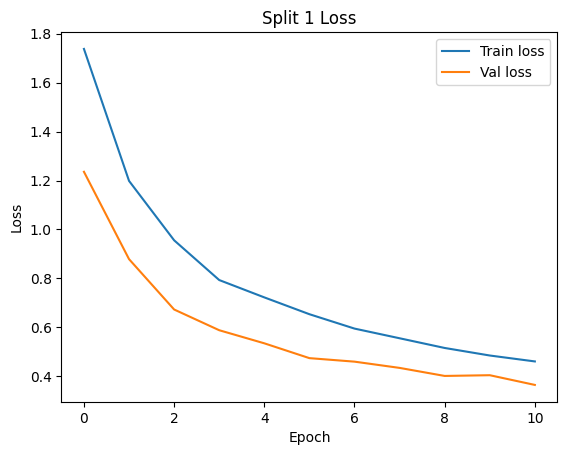

Hoàn thành huấn luyện cho split 1
============================== Split 2 ==============================
Epoch 0
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.7656 Acc: 0.3715



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.2943 Acc: 0.5795


Epoch 1
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.1923 Acc: 0.5989



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.8839 Acc: 0.7162


Epoch 2
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.9561 Acc: 0.6834



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.7362 Acc: 0.7659


Epoch 3
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.8154 Acc: 0.7306



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6477 Acc: 0.7892


Epoch 4
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.7219 Acc: 0.7630



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5549 Acc: 0.8209


Epoch 5
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.6465 Acc: 0.7879



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5093 Acc: 0.8396


Epoch 6
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5918 Acc: 0.8031



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4891 Acc: 0.8424


Epoch 7
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5552 Acc: 0.8162



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4477 Acc: 0.8565


Epoch 8
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5158 Acc: 0.8300



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4392 Acc: 0.8587


Epoch 9
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4794 Acc: 0.8433



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4213 Acc: 0.8583


Epoch 10
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4576 Acc: 0.8503



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.3856 Acc: 0.8851




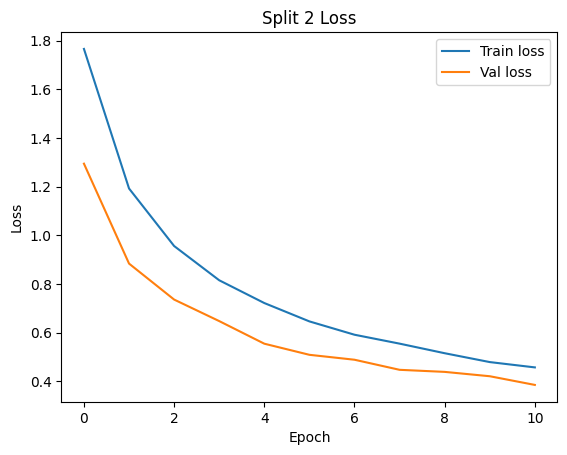

Hoàn thành huấn luyện cho split 2
============================== Split 3 ==============================
Epoch 0
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.7072 Acc: 0.3984



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.2735 Acc: 0.5816


Epoch 1
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.1844 Acc: 0.6064



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.9554 Acc: 0.7007


Epoch 2
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.9397 Acc: 0.6939



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.7574 Acc: 0.7617


Epoch 3
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.8006 Acc: 0.7385



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6402 Acc: 0.7913


Epoch 4
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.7039 Acc: 0.7683



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6320 Acc: 0.7945


Epoch 5
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.6433 Acc: 0.7886



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5332 Acc: 0.8315


Epoch 6
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5939 Acc: 0.8042



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5060 Acc: 0.8361


Epoch 7
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5499 Acc: 0.8197



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4923 Acc: 0.8357


Epoch 8
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5181 Acc: 0.8303



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4637 Acc: 0.8456


Epoch 9
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4820 Acc: 0.8426



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4257 Acc: 0.8611


Epoch 10
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4549 Acc: 0.8514



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4148 Acc: 0.8699




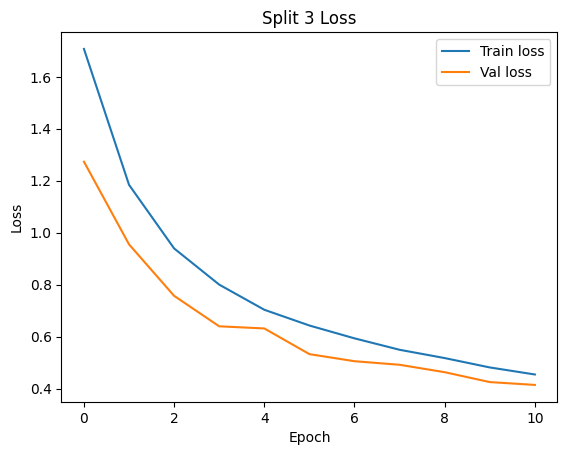

Hoàn thành huấn luyện cho split 3
============================== Split 4 ==============================
Epoch 0
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.7364 Acc: 0.3825



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.2489 Acc: 0.5862


Epoch 1
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.1582 Acc: 0.6109



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.8668 Acc: 0.7187


Epoch 2
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.9192 Acc: 0.6925



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6827 Acc: 0.7762


Epoch 3
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.7803 Acc: 0.7422



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5801 Acc: 0.8171


Epoch 4
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.6905 Acc: 0.7708



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5764 Acc: 0.8079


Epoch 5
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.6283 Acc: 0.7926



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4954 Acc: 0.8414


Epoch 6
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5837 Acc: 0.8084



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5074 Acc: 0.8372


Epoch 7
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5459 Acc: 0.8192



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4359 Acc: 0.8579


Epoch 8
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5139 Acc: 0.8286



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4272 Acc: 0.8664


Epoch 9
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4698 Acc: 0.8459



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4042 Acc: 0.8664


Epoch 10
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4494 Acc: 0.8531



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4053 Acc: 0.8675




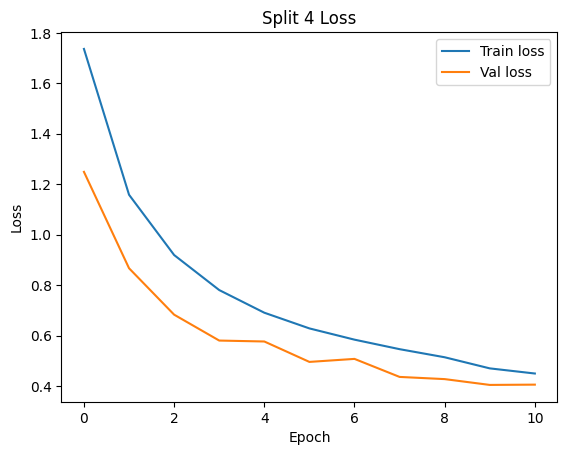

Hoàn thành huấn luyện cho split 4
============================== Split 5 ==============================
Epoch 0
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.7358 Acc: 0.3819



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.3124 Acc: 0.5597


Epoch 1
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 1.1946 Acc: 0.5965



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.9145 Acc: 0.6940


Epoch 2
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.9352 Acc: 0.6877



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.7057 Acc: 0.7751


Epoch 3
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.7882 Acc: 0.7385



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6353 Acc: 0.7899


Epoch 4
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.7063 Acc: 0.7671



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5458 Acc: 0.8241


Epoch 5
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.6382 Acc: 0.7876



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5450 Acc: 0.8160


Epoch 6
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5913 Acc: 0.8054



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4827 Acc: 0.8467


Epoch 7
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5428 Acc: 0.8200



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4685 Acc: 0.8410


Epoch 8
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.5053 Acc: 0.8346



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4025 Acc: 0.8731


Epoch 9
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4760 Acc: 0.8453



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.3929 Acc: 0.8749


Epoch 10
------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Train Loss: 0.4540 Acc: 0.8521



  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4066 Acc: 0.8636




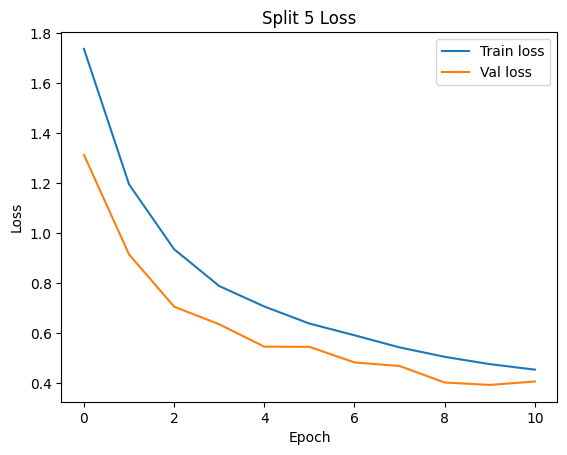

Hoàn thành huấn luyện cho split 5
Đã hoàn thành tất cả split.


In [33]:
splits = range(1, 6)
error_file_list = []  
base_dir = '/kaggle/input/cardataset-splits'
log_dir = '/kaggle/working/'
for split in splits:
    print(f"============================== Split {split} ==============================")

    # Đọc dữ liệu huấn luyện cho split hiện tại
    train_csv_path = f"{base_dir}/CarDataset-Splits-{split}-Train.csv"
    df_train = pd.read_csv(train_csv_path)
    df_train.columns = ['ImageFullPath', 'CategoryID']  
    # Tạo DataLoader
    data_loaders, train_dataset, val_dataset = generate_dataloaders(df_train, image_transforms, validation_split=0.1)
    # print(f"Train dataset size: {len(data_loaders['train'].dataset)}")
    # print(f"Validation dataset size: {len(data_loaders['val'].dataset)}")

    # Khởi tạo mô hình
    model = CustomVisionTransformerClassifier(num_target_classes=9)
    model = model.to(device)  # Di chuyển mô hình đến thiết bị (GPU nếu có)

    # Định nghĩa hàm mất mát, bộ tối ưu và lịch trình tốc độ học
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-6, weight_decay=1e-2)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    total_epochs = 11  # Số epoch để huấn luyện
    highest_accuracy = 0.0  # Độ chính xác tốt nhất ban đầu
    train_loss_log = []  # Lịch sử mất mát huấn luyện
    validation_loss_log = []  # Lịch sử mất mát validation

    for epoch in range(total_epochs):
        print(f"Epoch {epoch}")
        print('-' * 30)

        # Xử lý từng giai đoạn
        for stage in ['train', 'val']:
            model.train() if stage == 'train' else model.eval()  # Chế độ mô hình

            total_loss = 0.0
            total_corrects = 0
            # Lặp qua các batch
            # print(f"Number of batches in {stage}: {len(data_loaders[stage])}")
            for images, labels in tqdm(data_loaders[stage]):
                if images is None or labels is None:
                    continue
                try:
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(stage == 'train'):
                        predictions = model(images)
                        loss = loss_function(predictions, labels)

                        if stage == 'train':
                            loss.backward()
                            optimizer.step()

                    total_loss += loss.item() * images.size(0)
                    _, predictions_max = torch.max(predictions, 1)
                    total_corrects += (predictions_max == labels).sum().item()

                except (IOError, SyntaxError, UnidentifiedImageError, OSError) as error:
                    print(f"Lỗi xử lý batch: {error}")

            epoch_loss = total_loss / len(data_loaders[stage].dataset)
            epoch_accuracy = total_corrects / len(data_loaders[stage].dataset)

            print(f'{stage.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')

            if stage == 'train':
                train_loss_log.append(epoch_loss)
            else:
                validation_loss_log.append(epoch_loss)

            if stage == 'val' and epoch_accuracy > highest_accuracy:
                highest_accuracy = epoch_accuracy
                torch.save(model.state_dict(), os.path.join(log_dir, f'best_model_split_{split}.pth'))
            print()

        print()

    # Vẽ đồ thị mất mát
    plt.figure()
    plt.plot(train_loss_log, label='Train loss')
    plt.plot(validation_loss_log, label='Val loss')
    plt.title(f'Split {split} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(log_dir, f'loss_split_{split}.png'))
    plt.show()
    plt.close()

    print(f'Hoàn thành huấn luyện cho split {split}')

    # Thu thập tệp lỗi
    error_file_list.extend(train_dataset.error_files)
    error_file_list.extend(val_dataset.error_files)

# Ghi danh sách tệp lỗi vào file
with open(os.path.join(log_dir, 'error_files.txt'), 'w') as error_file:
    for file_path in error_file_list:
        error_file.write(file_path + "\n")

print('Đã hoàn thành tất cả split.')

# Evaluation

In [ ]:
# Store accuracies for each split
acc = []

# Loop through each split for evaluation
for split in splits:
    print(f"============================== Đánh giá split {split} ==============================")

    # Tạo DataLoader cho tập test
    test_csv_path = f"{base_dir}/CarDataset-Splits-{split}-Test.csv"
    test_dataloader, test_dataset = create_test_dataloader(test_csv_path, image_transforms)
    error_file_list.extend(test_dataset.error_files)  # Mở rộng danh sách các tệp lỗi với lỗi của tập test

    # Tải mô hình đã huấn luyện
    model = models.mobilenet_v3_large(weights='DEFAULT')
    model.classifier = nn.Sequential(
        nn.Linear(in_features=960, out_features=1280, bias=True),
        nn.Hardswish(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=9, bias=True)
    )
    model.load_state_dict(torch.load(os.path.join(log_dir, f'best_model_split_{split}.pth')))
    model = model.to(device)
    model.eval()  # Đặt mô hình vào chế độ đánh giá

    y_true = []
    y_pred = []

    # Đánh giá mô hình trên dữ liệu test
    for inputs, labels in tqdm(test_dataloader):
        if inputs is None or labels is None:
            continue
        try:
            inputs = inputs.to(device)  # Di chuyển inputs lên GPU nếu có sẵn
            labels = labels.to(device)  # Di chuyển labels lên GPU nếu có sẵn

            with torch.no_grad():
                outputs = model(inputs)  # Lan truyền tiến mà không tính toán gradient
                _, preds = torch.max(outputs, 1)  # Lấy dự đoán

            y_true.extend(labels.cpu().numpy())  # Thêm nhãn thực tế vào y_true
            y_pred.extend(preds.cpu().numpy())  # Thêm nhãn dự đoán vào y_pred
        except (IOError, SyntaxError, UnidentifiedImageError, OSError) as e:
            print(f"Lỗi xử lý batch: {e}")

    # Tính toán độ chính xác
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy for Split {split}: {accuracy * 100:.4f}%')
    acc.append(accuracy)

    # Hiển thị ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for Split {split}')
    plt.show()

# Tính toán và hiển thị độ chính xác trung bình
average_accuracy = np.mean(acc)
print("Accuracy 5 split:", acc)
print(f"Trung bình Accuracy cho 5 split: {average_accuracy * 100:.4f}%")
